In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import string
import re
import nltk
import warnings
warnings.filterwarnings("ignore")
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

In [ ]:
df=pd.read_csv('/content/drive/MyDrive/Summer 2022 Work/Recommendations_20 Shortlist - Sheet1.csv')
df = df[['Recommendation Text']]
df.columns = ['Text']

In [ ]:
df = df.dropna()

In [ ]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
from collections import  Counter
stopwords = nltk.corpus.stopwords.words('english')

def plot_top_ngrams_barchart(text, n):
    stop=set(stopwords)

    new= text.str.split()
    new=new.values.tolist()
    corpus=[word for i in new for word in i]

    def _get_top_ngram(corpus, n):
        vec = CountVectorizer(ngram_range=(n, n)).fit(corpus)
        bag_of_words = vec.transform(corpus)
        sum_words = bag_of_words.sum(axis=0) 
        words_freq = [(word, sum_words[0, idx]) 
                      for word, idx in vec.vocabulary_.items()]
        words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
        return words_freq

    top_n_bigrams=_get_top_ngram(text,n)[:10]
    x,y=map(list,zip(*top_n_bigrams))
    sns.barplot(x=y,y=x)

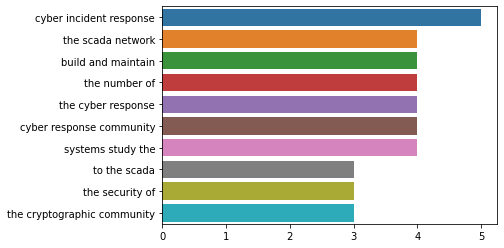

In [ ]:
plot_top_ngrams_barchart(df['Text'], n=3)

In [ ]:
!pip install pyLDAvis

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.7 MB 8.9 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
    Preparing wheel metadata ... done
  Created wheel for pyLDAvis: filename=pyLDAvis-3.3.1-py2.py3-none-any.whl size=136898 sha256=80104be2669e8ad4d982c943e06d01bbf358bf1b370612757dfad20932f35294
  Stored in directory: /root/.cache/pip/wheels/c9/21/f6/17bcf2667e8a68532ba2fbf6d5c72fdf4c7f7d9abfa4852d2f
  Created wheel for sklearn: filename=sklearn-0.0-py2.py3-none-any.whl size=1310 sha256=5ef0015294176eccff2f1ba54b8a7c83175b92d8a3556849293ddbffa9f29074
  Stored in directory: /root/.cache/pip/wheels/46/ef/c3/157e41f5ee1372d1be90b09f74f82b10e391eaacca8f22d33e
Successfully built pyLDAvis sklearn


In [ ]:
import gensim
from nltk.stem import WordNetLemmatizer,PorterStemmer
from nltk.tokenize import word_tokenize
import pyLDAvis.gensim_models as gensim
import pyLDAvis
from gensim.corpora import Dictionary
from gensim.models import LdaMulticore

def get_lda_objects(text):   
    stop=set(nltk.corpus.stopwords.words('english'))

    
    def _preprocess_text(text):
        corpus=[]
        stem=PorterStemmer()
        lem=WordNetLemmatizer()
        for news in text:
            words=[w for w in word_tokenize(news) if (w not in stop)]

            words=[lem.lemmatize(w) for w in words if len(w)>2]

            corpus.append(words)
        return corpus
    
    corpus=_preprocess_text(text)
    
    dic=Dictionary(corpus)
    bow_corpus = [dic.doc2bow(doc) for doc in corpus]
    
    lda_model =  LdaMulticore(bow_corpus, 
                                   num_topics = 4, 
                                   id2word = dic,                                    
                                   passes = 10,
                                   workers = 2)
    
    return lda_model, bow_corpus, dic

def plot_lda_vis(lda_model, bow_corpus, dic):
    pyLDAvis.enable_notebook()
    vis = gensim.prepare(lda_model, bow_corpus, dic)
    return vis

/usr/local/lib/python3.7/dist-packages/past/types/oldstr.py:5: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import Iterable


In [ ]:
import nltk
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


True

In [ ]:
lda_model, bow_corpus, dic = get_lda_objects(df['Text'])

In [ ]:
lda_model.show_topics()

[(0,
  '0.012*"cybersecurity" + 0.011*"must" + 0.011*"behavior" + 0.010*"DHS" + 0.010*"cryptographic" + 0.010*"NIST" + 0.010*"malware" + 0.010*"sample" + 0.008*"security" + 0.006*"agency"'),
 (1,
  '0.024*"response" + 0.022*"cyber" + 0.011*"incident" + 0.010*"community" + 0.010*"security" + 0.009*"network" + 0.009*"information" + 0.008*"Establish" + 0.008*"SCADA" + 0.008*"procedure"'),
 (2,
  '0.020*"system" + 0.018*"IoT" + 0.018*"Study" + 0.015*"security" + 0.013*"device" + 0.012*"information" + 0.012*"Recommendation" + 0.010*"Cyber" + 0.010*"software" + 0.009*"cyber"'),
 (3,
  '0.016*"Control" + 0.011*"DoD" + 0.007*"device" + 0.007*"service" + 0.007*"Access" + 0.007*"Build" + 0.007*"Vehicle" + 0.007*"Limit" + 0.007*"maintain" + 0.007*"application"')]

In [ ]:
pyLDAvis.enable_notebook()
vis = gensim.prepare(lda_model, bow_corpus, dic)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1     -0.135200 -0.011769       1        1  50.914379
2      0.018895  0.093793       2        1  20.478268
0      0.046983 -0.103970       3        1  16.653079
3      0.069323  0.021946       4        1  11.954274, topic_info=            Term       Freq      Total Category  logprob  loglift
830        Study   7.000000   7.000000  Default  30.0000  30.0000
228          IoT   7.000000   7.000000  Default  29.0000  29.0000
921      Control   3.000000   3.000000  Default  28.0000  28.0000
107       system  14.000000  14.000000  Default  27.0000  27.0000
39        device   8.000000   8.000000  Default  26.0000  26.0000
..           ...        ...        ...      ...      ...      ...
39        device   1.552033   8.504601   Topic4  -4.9484   0.4230
136   capability   1.072715   6.524756   Topic4  -5.3178   0.3187
66       network   1.074032  10.685516   Topic4  -5.3166  -0.1734
55   information   1.075837  14.336566   Topic4  -5.3149  -0.4656
97      security   1.083875  18.030673   Topic4  -5.3074  -0.6875

[226 rows x 6 columns], token_table=      Topic      Freq           Term
term                                
917       4  0.979029         Access
220       4  0.919249    Acquisition
221       4  0.919259  Architectures
779       3  0.577237         Assess
730       1  0.791730        Attacks
...     ...       ...            ...
111       1  1.001735           used
112       1  0.423236           user
112       4  0.423236           user
166       4  0.637773        version
287       3  0.577147           work

[259 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 3, 1, 4])

In [ ]:
from wordcloud import WordCloud

def plot_wordcloud(text):
    stop=set(nltk.corpus.stopwords.words('english'))

    def _preprocess_text(text):
        corpus=''
        stem=PorterStemmer()
        lem=WordNetLemmatizer()
        for news in text:
            words=[w for w in word_tokenize(news) if (w not in stop)]

            words=[lem.lemmatize(w) for w in words if len(w)>2]

            corpus += ' '.join(words)
        return corpus
    
    corpus=_preprocess_text(text)
    
    wordcloud = WordCloud(
        background_color='salmon', colormap='Pastel1',
        stopwords=stop,
        max_words=100,
        max_font_size=30, 
        scale=3,
        random_state=1)
    
    wordcloud=wordcloud.generate(corpus)

    fig = plt.figure(1, figsize=(20, 15))
    plt.axis('off')
 
    plt.imshow(wordcloud)
    plt.show()

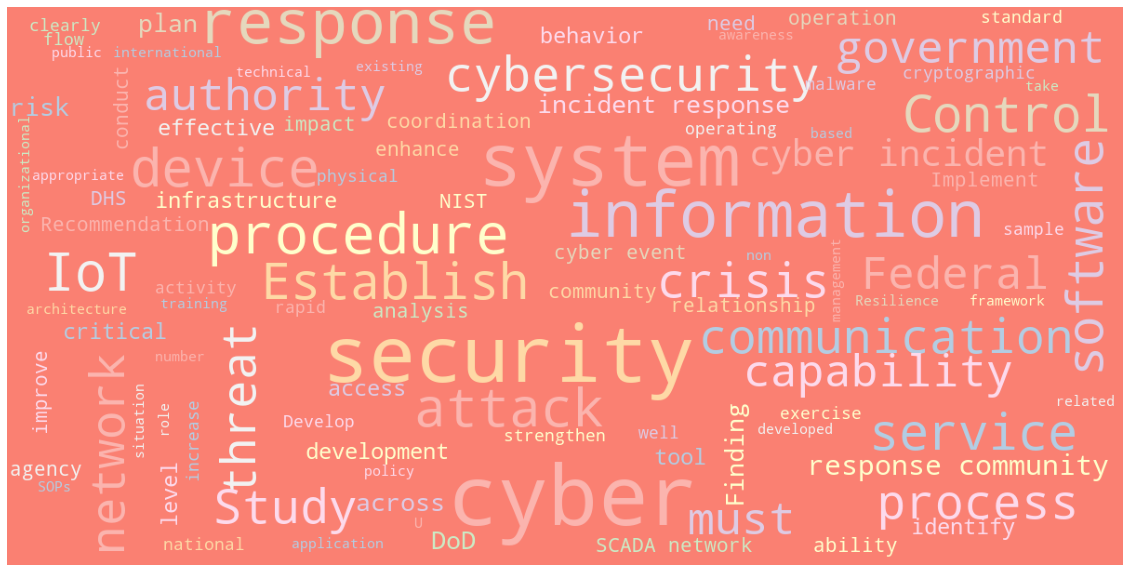

In [ ]:
plot_wordcloud(df['Text'])

## Sentence embeddings

In [ ]:
!pip install sentence-transformers

In [ ]:
import seaborn as sns
from sentence_transformers import SentenceTransformer

sbert_model = SentenceTransformer('bert-base-nli-mean-tokens')

Downloading:   0%|          | 0.00/391 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/190 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/3.95k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/625 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/122 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/438M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/399 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/229 [00:00<?, ?B/s]

In [ ]:
sentences = df['Text'].to_numpy()
sentence_embeddings = sbert_model.encode(sentences)

In [ ]:
sentence_embeddings.shape

(19, 768)

In [ ]:
def cosine(u, v):
    return np.dot(u, v) / (np.linalg.norm(u) * np.linalg.norm(v))

matrix = np.identity(sentence_embeddings.shape[0])
for i in range(matrix.shape[0]):
  for j in range(i,matrix.shape[0]):
    matrix[i][j] = cosine(sentence_embeddings[i],sentence_embeddings[j])
    matrix[j][i] = matrix[i][j]

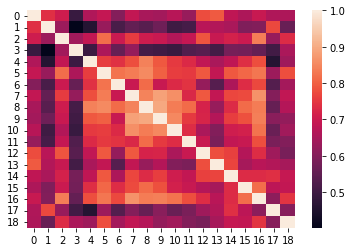

In [ ]:
ax = sns.heatmap(matrix)

In [ ]:
recomm = np.mean(sentence_embeddings,axis=0)

In [ ]:
!pip install tika

In [ ]:
from tika import parser

raw = parser.from_file('/content/drive/MyDrive/CySyphus Master Documents/Scraped Files/Cysyphus Phase 1/NIST(1-100)/Reports(NIST1-100)"Command, Control, and Communications"/(2G8)%20Global%20Nav%20-%20About%20Us%20-%20Budget%20-%20Budget%20Entries%20-%20FY2009%20(Approved).pdf')

2022-08-27 21:34:58,488 [MainThread  ] [INFO ]  Retrieving http://search.maven.org/remotecontent?filepath=org/apache/tika/tika-server/1.24/tika-server-1.24.jar to /tmp/tika-server.jar.
INFO:tika.tika:Retrieving http://search.maven.org/remotecontent?filepath=org/apache/tika/tika-server/1.24/tika-server-1.24.jar to /tmp/tika-server.jar.
2022-08-27 21:34:59,660 [MainThread  ] [INFO ]  Retrieving http://search.maven.org/remotecontent?filepath=org/apache/tika/tika-server/1.24/tika-server-1.24.jar.md5 to /tmp/tika-server.jar.md5.
INFO:tika.tika:Retrieving http://search.maven.org/remotecontent?filepath=org/apache/tika/tika-server/1.24/tika-server-1.24.jar.md5 to /tmp/tika-server.jar.md5.
2022-08-27 21:35:00,106 [MainThread  ] [WARNI]  Failed to see startup log message; retrying...


In [ ]:
text = raw['content'].replace('\n','')

In [ ]:
tokens = nltk.sent_tokenize(text)

In [ ]:
relevant = []
distances = []

for sentence in tokens:
  embedd = sbert_model.encode(sentence)
  distances.append(cosine(recomm, embedd))

In [ ]:
ind = np.argpartition(distances, -4)[-4:]
top4 = np.array(tokens)[ind]

In [ ]:
top4

array(['Narrative Title FY 2007 FY 2008 FY 2009 Defensive Autonomous Systems  0.000 0.000 3.000 (U) The Defense Autonomous Systems goal is to allow the military to more closely monitor and identify remotely-controlled computers (bots) and bot slaves within military and government networks, as well as increase the monitoring capability of our defenders.',
       'FY 2008 Plans: − Develop additional general strategies to automatically immunize systems against new attacks and preempt insider attacks; combining and correlating information from system layers using direct user challenges.',
       '− Develop additional general strategies to automatically immunize systems against new attacks and preempt insider attacks; enabling anomaly detection, combining and correlating information from system layers, and using direct user challenges.',
       'To address this problem, the CBMANET program will exploit recent optimization-theoretic breakthroughs, recent information-theoretic breakthroughs, 